# Capstone Project - NLP Chatbot

### DOMAIN: 
Industrial safety. NLP based Chatbot.

### CONTEXT:
The database comes from one of the biggest industry in Brazil and in the world. It is an urgent need for industries/companies around the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

### DATA DESCRIPTION:
This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an occurrence of an accident.

### Columns description:
* Data: timestamp or time/date information
* Countries: which country the accident occurred (anonymised)
* Local: the city where the manufacturing plant is located (anonymised)
* Industry sector: which sector the plant belongs to
* Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
* Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have   been (due to other factors involved in the accident)
* Gender: if the person is male of female
* Employee or Third Party: if the injured person is an employee or a third party
* Critical Risk: some description of the risk involved in the accident
* Description: Detailed description of how the accident happened.

Link to download the dataset: https://drive.google.com/file/d/1_GmrRP1S2OIa02KlfOBNkYa8uxazGbfE/view?usp=sharing,
Original dataset link: https://www.kaggle.com/ihmstefanini/industrial-safety-and-health-analytics-database

### PROJECT OBJECTIVE:
Design a ML/DL based chatbot utility which can help the professionals to highlight the safety risk as per the incident description.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/AIML/Capstone

/content/drive/MyDrive/AIML/Capstone


In [ ]:
#! git clone https://github.com/shyamsparrow/Jan-G4---NLP-Chatbot.git

In [ ]:
%cd /content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot

/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot


In [ ]:
!git pull

Already up to date.


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, LSTM,  Embedding, Dropout, Bidirectional, GlobalMaxPool1D

from keras.utils import np_utils
from keras.layers.merge import Concatenate
#from keras.utils import plot_model

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Keras pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# **Simple Transformers With Pre-processed Data**

In [ ]:
industry_df = pd.read_csv("industry_df_with_stopwords.csv")

In [ ]:
# Select input and output features

X_text = industry_df['Description_preprocessed']
y_text = industry_df['Potential_Accident_Level']

In [ ]:
# Encode labels in column 'Potential Accident Level'and Convert into one-hot encoded vectors:
y_text = LabelEncoder().fit_transform(y_text)
y_text = np_utils.to_categorical(y_text)

In [ ]:
# Divide our data into testing and training sets:
X_train, X_test, y_train, y_test = train_test_split(X_text, y_text, test_size = 0.20, random_state = 155)

print('X_train shape : ({0})'.format(X_train.shape))
print('y_train shape : ({0},)'.format(y_train.shape))
print('X_test shape : ({0})'.format(X_test.shape))
print('y_test shape : ({0},)'.format(y_test.shape))

X_train shape : ((328,))
y_train shape : ((328, 5),)
X_test shape : ((83,))
y_test shape : ((83, 5),)


In [ ]:
# The first step in word embeddings is to convert the words into thier corresponding numeric indexes.
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
industry_df['nb_words'] = industry_df['Description_preprocessed'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(industry_df['nb_words'].min()))
print('Maximum number of words: {}'.format(industry_df['nb_words'].max()))

Minimum number of words: 16
Maximum number of words: 183


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size:", vocab_size)

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size: 2795


In [ ]:
%cd /content/drive/MyDrive/AIML/Capstone

/content/drive/MyDrive/AIML/Capstone


In [ ]:
print('Indexing word vectors.')

embeddings_dictionary = {}
f = open('glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_dictionary))

Indexing word vectors.
Found 400000 word vectors.


In [ ]:
pickle.dump(embeddings_dictionary, open('/content/drive/MyDrive/AIML/Capstone/embeddings.pickle', 'wb'))

In [ ]:
infile = open('/content/drive/MyDrive/AIML/Capstone/embeddings.pickle','rb')
embeddings_dictionary = pickle.load(infile)

In [ ]:
embedding_size = 200
embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_matrix.shape

(2795, 200)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-4)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-4)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



In [ ]:
    def get_config(self):
        config = super().get_config()
        config.update({
            "att": self.att,
            "ffn": self.ffn,
            "layernorm1": self.layernorm1,
            "layernorm2": self.layernorm2,
            "dropout1": self.dropout1,
            "dropout2": self.dropout2,
        })
        return config



    def get_config(self):
        config = super().get_config()
        config.update({
            "token_emb": self.token_emb,
            "pos_emb": self.pos_emb,
        })
        return config

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 300)         898500    
 g_29 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_29 (Trans  (None, 200, 300)         1926500   
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_29  (None, 300)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_118 (Dropout)       (None, 300)               0  

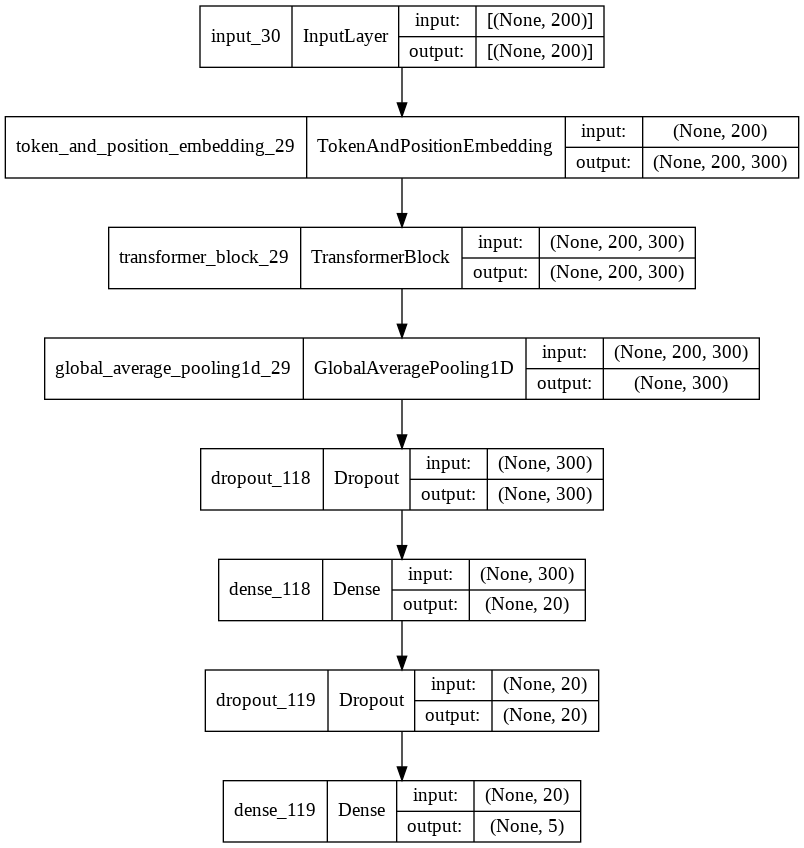

In [ ]:
embed_dim = 300  # Embedding size for each token
num_heads = 5  # Number of attention heads
ff_dim = 200 # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(200,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
tf.keras.utils.plot_model(model, to_file='transformer.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 4
batch_size = 32
loss = "categorical_crossentropy"
opt = keras.optimizers.Adam(lr=1e-3)

metrics = ["acc"]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

model.compile(optimizer=opt, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks = [callback])

Epoch 1/4
11/11 [==============================] - 4s 161ms/step - loss: 1.6866 - acc: 0.2805 - val_loss: 1.5816 - val_acc: 0.3855
Epoch 2/4
11/11 [==============================] - 1s 113ms/step - loss: 1.5805 - acc: 0.3323 - val_loss: 1.5326 - val_acc: 0.3855
Epoch 3/4
11/11 [==============================] - 1s 115ms/step - loss: 1.5691 - acc: 0.3140 - val_loss: 1.5102 - val_acc: 0.3855
Epoch 4/4
11/11 [==============================] - 1s 116ms/step - loss: 1.5412 - acc: 0.3323 - val_loss: 1.4988 - val_acc: 0.3855


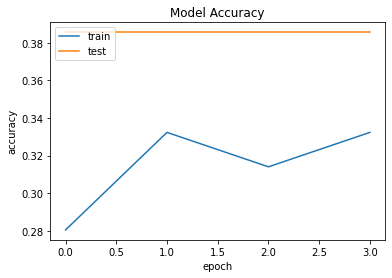

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

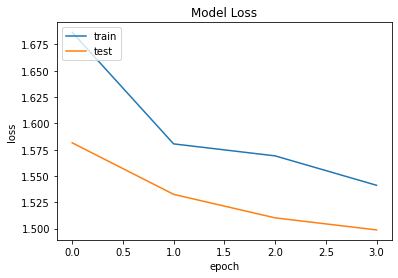

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

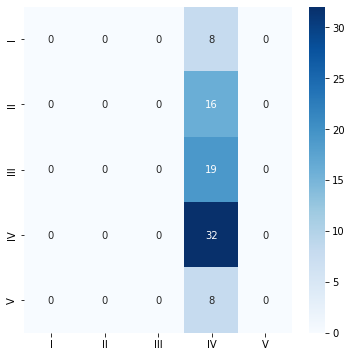

In [ ]:
#predict the labels
y_predicted_labels = model.predict(X_test)
y_pred_index = np.argmax(y_predicted_labels,axis=1)
y_original = np.argmax(y_test, axis =1)

#plot the confusion matrix
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label,fmt='g');

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        19
           3       0.39      1.00      0.56        32
           4       0.00      0.00      0.00         8

    accuracy                           0.39        83
   macro avg       0.08      0.20      0.11        83
weighted avg       0.15      0.39      0.21        83



We can observe that the model is predicting all the classes as IV.

In [ ]:
# try the above with different learning rate
lr = 1e-04

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 300)         898500    
 g_31 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_31 (Trans  (None, 200, 300)         1926500   
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_31  (None, 300)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_126 (Dropout)       (None, 300)               0  

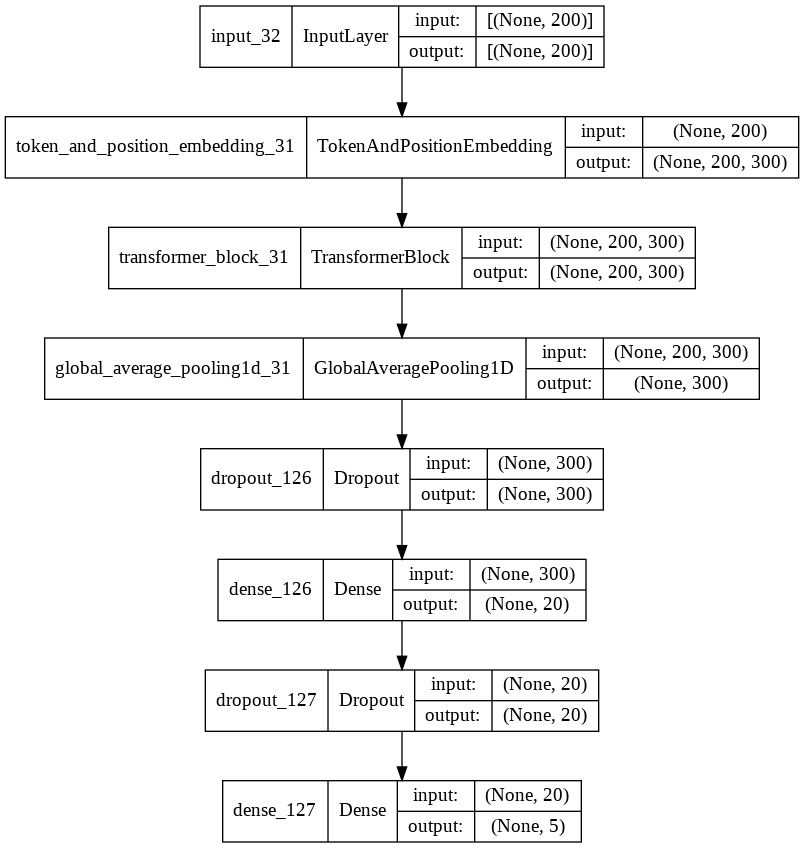

In [ ]:
embed_dim = 300  # Embedding size for each token
num_heads = 5  # Number of attention heads
ff_dim = 200 # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(200,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
tf.keras.utils.plot_model(model, to_file='transformer.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 4
batch_size = 32
loss = "categorical_crossentropy"
opt = keras.optimizers.Adam(lr=lr)

metrics = ["acc"]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

model.compile(optimizer=opt, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks = [callback])

Epoch 1/4
11/11 [==============================] - 4s 160ms/step - loss: 1.6484 - acc: 0.2957 - val_loss: 1.5345 - val_acc: 0.2289
Epoch 2/4
11/11 [==============================] - 1s 116ms/step - loss: 1.5181 - acc: 0.2988 - val_loss: 1.4731 - val_acc: 0.3614
Epoch 3/4
11/11 [==============================] - 1s 114ms/step - loss: 1.4843 - acc: 0.3384 - val_loss: 1.4835 - val_acc: 0.2892
Epoch 4/4
11/11 [==============================] - 1s 116ms/step - loss: 1.4879 - acc: 0.3201 - val_loss: 1.4644 - val_acc: 0.2892


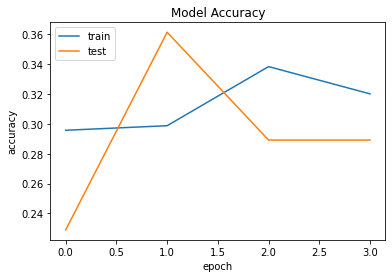

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

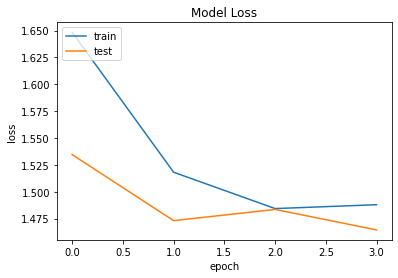

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

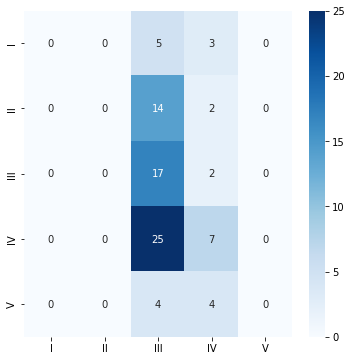

In [ ]:
#predict the labels
y_predicted_labels = model.predict(X_test)
y_pred_index = np.argmax(y_predicted_labels,axis=1)
y_original = np.argmax(y_test, axis =1)

#plot the confusion matrix
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label,fmt='g');

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00        16
           2       0.26      0.89      0.40        19
           3       0.39      0.22      0.28        32
           4       0.00      0.00      0.00         8

    accuracy                           0.29        83
   macro avg       0.13      0.22      0.14        83
weighted avg       0.21      0.29      0.20        83



We can observe that model is predicting maximum as III and IV.

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-4)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-4)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



In [ ]:
    def get_config(self):
        config = super().get_config()
        config.update({
            "att": self.att,
            "ffn": self.ffn,
            "layernorm1": self.layernorm1,
            "layernorm2": self.layernorm2,
            "dropout1": self.dropout1,
            "dropout2": self.dropout2,
        })
        return config



    def get_config(self):
        config = super().get_config()
        config.update({
            "token_emb": self.token_emb,
            "pos_emb": self.pos_emb

        })
        return config

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 300)         898500    
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_1 (Transf  (None, 200, 300)         1926500   
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 300)               0   

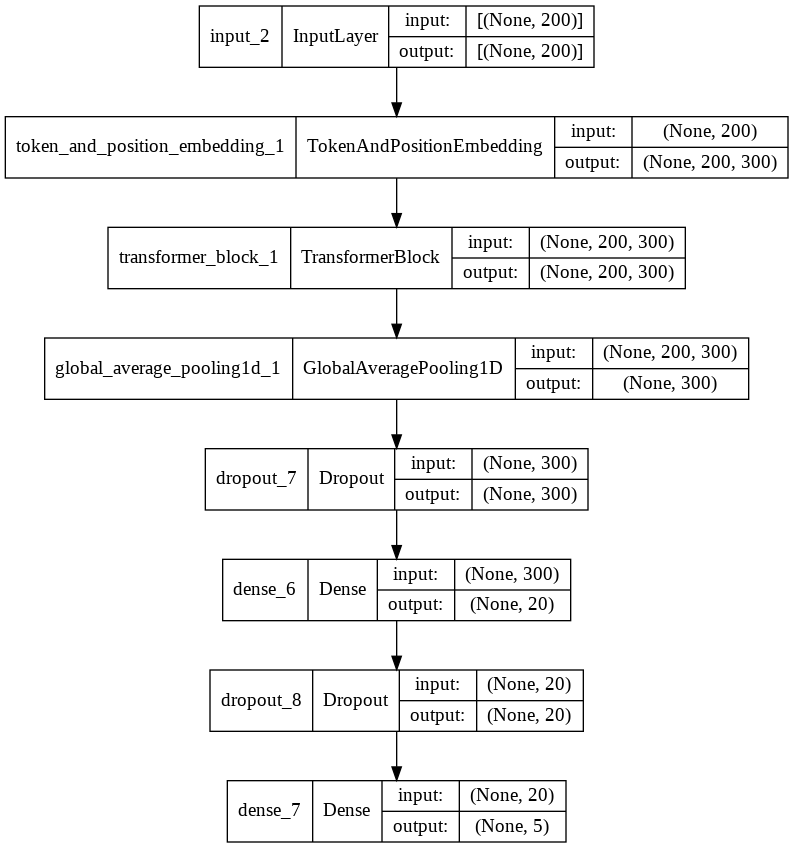

In [ ]:
embed_dim = 300  # Embedding size for each token
num_heads = 5  # Number of attention heads
ff_dim = 200 # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(200,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
tf.keras.utils.plot_model(model, to_file='transformer.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 4
batch_size = 32
loss = "categorical_crossentropy"
opt = keras.optimizers.Adam(lr=1e-04)

metrics = ["acc"]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

model.compile(optimizer=opt, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks = [callback])

Epoch 1/4
11/11 [==============================] - 34s 3s/step - loss: 1.6535 - acc: 0.2043 - val_loss: 1.5249 - val_acc: 0.2289
Epoch 2/4
11/11 [==============================] - 25s 2s/step - loss: 1.4903 - acc: 0.2957 - val_loss: 1.5212 - val_acc: 0.1928
Epoch 3/4
11/11 [==============================] - 28s 3s/step - loss: 1.4865 - acc: 0.2591 - val_loss: 1.5004 - val_acc: 0.2410
Epoch 4/4
11/11 [==============================] - 27s 2s/step - loss: 1.5114 - acc: 0.2470 - val_loss: 1.4830 - val_acc: 0.3735


In [ ]:
# save the model
model.save('/content/drive/MyDrive/AIML/Capstone/Models and Results/SimpleTransformer')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AIML/Capstone/Models and Results/SimpleTransformer/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AIML/Capstone/Models and Results/SimpleTransformer/assets


In [ ]:
SimpleTransformerModel = load_model('/content/drive/MyDrive/AIML/Capstone/Models and Results/SimpleTransformer')

In [ ]:
y_pred = SimpleTransformerModel.predict(X_test, verbose=0) # Multiclass
y_pred_index = np.argmax(y_pred,axis=1)
y_original = np.argmax(y_test, axis =1)

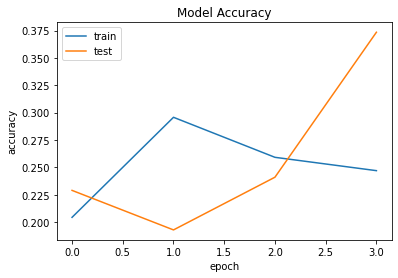

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

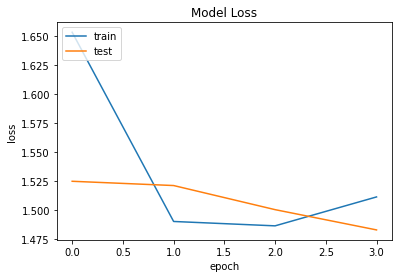

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

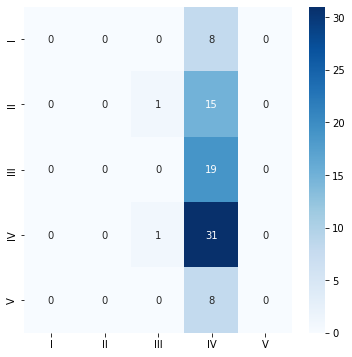

In [ ]:
#predict the labels
y_predicted_labels = model.predict(X_test)
y_pred_index = np.argmax(y_predicted_labels,axis=1)
y_original = np.argmax(y_test, axis =1)

#plot the confusion matrix
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label,fmt='g');

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        19
           3       0.38      0.97      0.55        32
           4       0.00      0.00      0.00         8

    accuracy                           0.37        83
   macro avg       0.08      0.19      0.11        83
weighted avg       0.15      0.37      0.21        83



We can observe that the model is predicting all the classes as IV.

Lets see the proportion of each class in dataset

In [ ]:
industry_df.Potential_Accident_Level.value_counts()

IV     138
III    106
II      95
I       43
V       29
Name: Potential_Accident_Level, dtype: int64

In [ ]:
# proportion in train data set

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot/industry_df_with_stopwords.csv")

In [ ]:
# Select input and output features

text = df['Description_preprocessed']
target = df['Potential_Accident_Level']

In [ ]:
# Divide our data into testing and training sets:
train,test = train_test_split(df[['Description_preprocessed','Potential_Accident_Level']], test_size = 0.20, random_state = 155)

In [ ]:
train.Potential_Accident_Level.value_counts()

IV     106
III     87
II      79
I       35
V       21
Name: Potential_Accident_Level, dtype: int64

We have imbalanced dataset in training set.

In [ ]:
with open('/content/drive/MyDrive/AIML/Capstone/result_df.csv', "rb") as f:
  result_df = pickle.load(f)

In [ ]:
y_pred = SimpleTransformerModel.predict(X_test, verbose=0) # Multiclass
y_pred_index = np.argmax(y_pred,axis=1)
y_original = np.argmax(y_test, axis =1)

In [ ]:
_,tr_accuracy = SimpleTransformerModel.evaluate(X_train,y_train) 
_,te_accuracy = SimpleTransformerModel.evaluate(X_test,y_test) 

F1_sre= f1_score(y_original,y_pred_index, average='micro')
tr_accuracy,te_accuracy,F1_sre

3/3 [==============================] - 2s 627ms/step - loss: 1.4830 - acc: 0.3735


(0.3414634168148041, 0.3734939694404602, 0.37349397590361444)

In [ ]:
result_df.loc[len(result_df.index)] = ['Simple Transformer Model', tr_accuracy, te_accuracy,F1_sre]
result_df.to_csv('/content/drive/MyDrive/AIML/Capstone/Models and Results/result_df.csv')
result_df

,Model,Train_accuracy,Test_accuracy,F1_score
0,LogReg,0.890244,0.890244,0.373494
1,Naive Bayes,1.000000,1.000000,0.421687
2,KNN,0.591463,0.591463,0.361446
3,SVM,0.990854,0.990854,0.361446
4,Decision Tree,0.512195,0.512195,0.313253
5,RandomForest,0.612805,0.612805,0.373494
6,Bagging,1.000000,1.000000,0.373494
7,AdaBoost,0.393293,0.393293,0.349398
8,Gradient Boost,0.920732,0.920732,0.325301
9,XGBoost,0.951220,0.951220,0.313253


# **Try Simple Transformer With Training Data Augmented**

In [ ]:
# Load augmented data
infile = open('/content/drive/MyDrive/AIML/Train_Test_augment.pickle','rb')
X_train,y_train,X_test,y_test = pickle.load(infile)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-4)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-4)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
    def get_config(self):
        config = super().get_config()
        config.update({
            "att": self.att,
            "ffn": self.ffn,
            "layernorm1": self.layernorm1,
            "layernorm2": self.layernorm2,
            "dropout1": self.dropout1,
            "dropout2": self.dropout2,
        })
        return config



    def get_config(self):
        config = super().get_config()
        config.update({
            "token_emb": self.token_emb,
            "pos_emb": self.pos_emb,
        })
        return config

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embed_dim = 300  # Embedding size for each token
num_heads = 5  # Number of attention heads
ff_dim = 200 # Hidden layer size in feed forward network inside transformer
vocab_size = 3446
maxlen = 200
inputs = layers.Input(shape=(200,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 300)         1093800   
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_2 (Transf  (None, 200, 300)         1926500   
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_2   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_12 (Dropout)        (None, 300)               0   

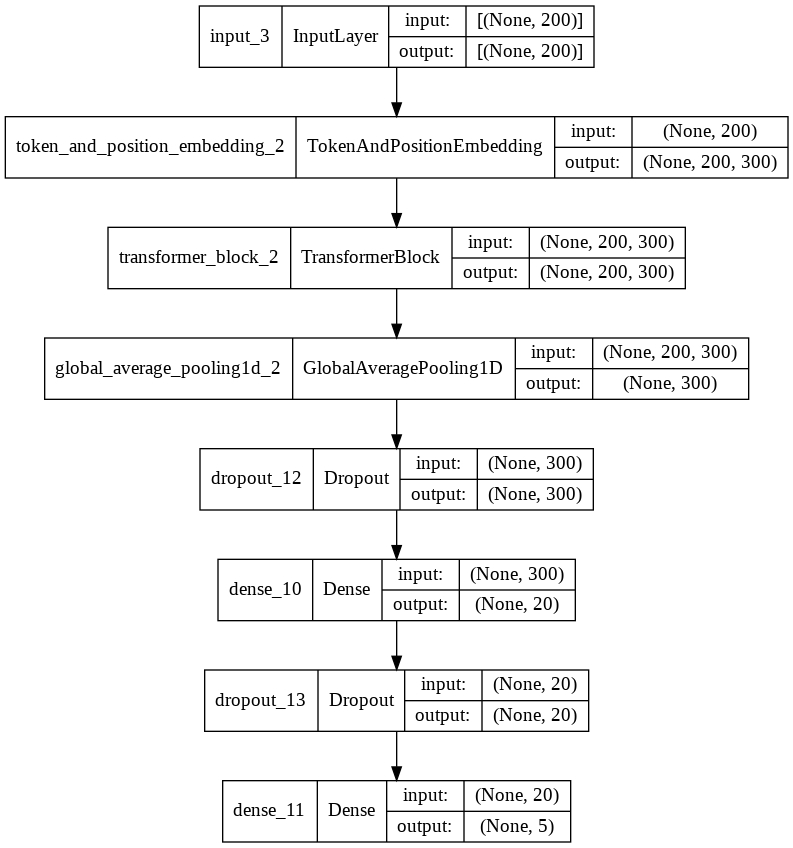

In [ ]:
tf.keras.utils.plot_model(model, to_file='transformer.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 4
batch_size = 32
loss = "categorical_crossentropy"
opt = keras.optimizers.Adam(lr=1e-04)

metrics = ["acc"]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

model.compile(optimizer=opt, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks = [callback])

Epoch 1/4
21/21 [==============================] - 51s 2s/step - loss: 1.5362 - acc: 0.2957 - val_loss: 1.3986 - val_acc: 0.3494
Epoch 2/4
21/21 [==============================] - 49s 2s/step - loss: 1.4970 - acc: 0.3476 - val_loss: 1.4067 - val_acc: 0.3253
Epoch 3/4
21/21 [==============================] - 48s 2s/step - loss: 1.4675 - acc: 0.3338 - val_loss: 1.3974 - val_acc: 0.3012
Epoch 4/4
21/21 [==============================] - 50s 2s/step - loss: 1.4593 - acc: 0.3582 - val_loss: 1.4064 - val_acc: 0.3253


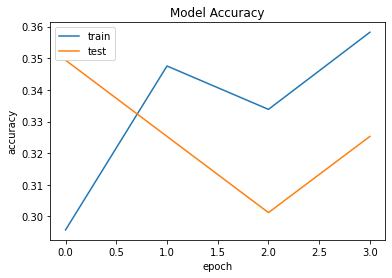

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

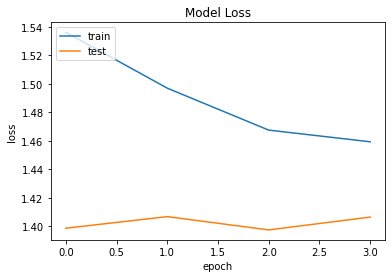

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

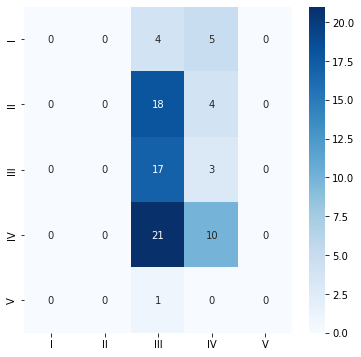

In [ ]:
#predict the labels
y_predicted_labels = model.predict(X_test)
y_pred_index = np.argmax(y_predicted_labels,axis=1)
y_original = np.argmax(y_test, axis =1)

#plot the confusion matrix
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label,fmt='g');

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        22
           2       0.28      0.85      0.42        20
           3       0.45      0.32      0.38        31
           4       0.00      0.00      0.00         1

    accuracy                           0.33        83
   macro avg       0.15      0.23      0.16        83
weighted avg       0.24      0.33      0.24        83



In the above classification report we can observe that using the augmented data also, the model is classifying most of the classes as III and IV.

In [ ]:
# try with different learning rate
# take lr = 1e-05

In [ ]:
embed_dim = 300  # Embedding size for each token
num_heads = 5  # Number of attention heads
ff_dim = 200 # Hidden layer size in feed forward network inside transformer
vocab_size = 3446
maxlen = 200
inputs = layers.Input(shape=(200,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 300)         1093800   
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_3 (Transf  (None, 200, 300)         1926500   
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_3   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_16 (Dropout)        (None, 300)               0   

In [ ]:
epochs = 4
batch_size = 32
loss = "categorical_crossentropy"
opt = keras.optimizers.Adam(lr=4e-05)

metrics = ["acc"]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

model.compile(optimizer=opt, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks = [callback])

Epoch 1/4
21/21 [==============================] - 50s 2s/step - loss: 1.6177 - acc: 0.1814 - val_loss: 1.5912 - val_acc: 0.1084
Epoch 2/4
21/21 [==============================] - 48s 2s/step - loss: 1.5761 - acc: 0.2043 - val_loss: 1.4428 - val_acc: 0.3373
Epoch 3/4
21/21 [==============================] - 48s 2s/step - loss: 1.5204 - acc: 0.3201 - val_loss: 1.4108 - val_acc: 0.3494
Epoch 4/4
21/21 [==============================] - 49s 2s/step - loss: 1.4780 - acc: 0.3323 - val_loss: 1.4197 - val_acc: 0.3133


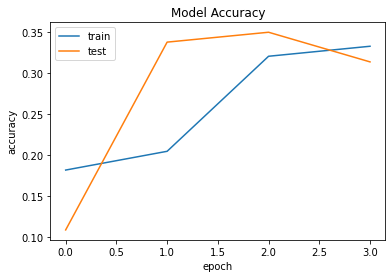

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

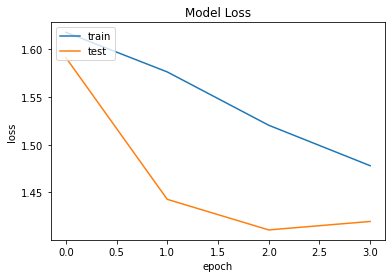

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

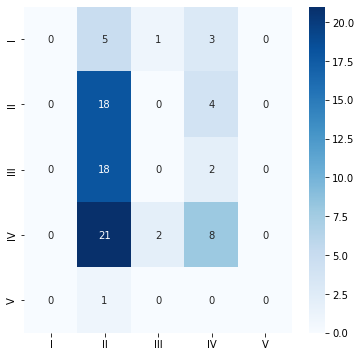

In [ ]:
#predict the labels
y_predicted_labels = model.predict(X_test)
y_pred_index = np.argmax(y_predicted_labels,axis=1)
y_original = np.argmax(y_test, axis =1)

#plot the confusion matrix
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label,fmt='g');

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.29      0.82      0.42        22
           2       0.00      0.00      0.00        20
           3       0.47      0.26      0.33        31
           4       0.00      0.00      0.00         1

    accuracy                           0.31        83
   macro avg       0.15      0.22      0.15        83
weighted avg       0.25      0.31      0.24        83



In [ ]:
# save the model
model.save('/content/drive/MyDrive/AIML/Capstone/Models and Results/SimpleTransformer_Aug')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AIML/Capstone/Models and Results/SimpleTransformer_Aug/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AIML/Capstone/Models and Results/SimpleTransformer_Aug/assets


In [ ]:
SimpleTransformer_Aug = load_model('/content/drive/MyDrive/AIML/Capstone/Models and Results/SimpleTransformer_Aug')

In [ ]:
y_pred = SimpleTransformer_Aug.predict(X_test, verbose=0) # Multiclass
y_pred_index = np.argmax(y_pred,axis=1)
y_original = np.argmax(y_test, axis =1)

In [ ]:
_,tr_accuracy = SimpleTransformer_Aug.evaluate(X_train,y_train) 
_,te_accuracy = SimpleTransformer_Aug.evaluate(X_test,y_test) 

F1_sre= f1_score(y_original,y_pred_index, average='weighted')
tr_accuracy,te_accuracy,F1_sre

3/3 [==============================] - 2s 625ms/step - loss: 1.4197 - acc: 0.3133


(0.37042683362960815, 0.3132530152797699, 0.23675879990550433)

In [ ]:
result_df.loc[len(result_df.index)] = ['Simple Transformer Model Aug', tr_accuracy, te_accuracy,F1_sre] 
result_df.to_csv('/content/drive/MyDrive/AIML/Capstone/Models and Results/result_df.csv')
result_df

,Model,Train_accuracy,Test_accuracy,F1_score
0,LogReg,0.890244,0.890244,0.373494
1,Naive Bayes,1.000000,1.000000,0.421687
2,KNN,0.591463,0.591463,0.361446
3,SVM,0.990854,0.990854,0.361446
4,Decision Tree,0.512195,0.512195,0.313253
5,RandomForest,0.612805,0.612805,0.373494
6,Bagging,1.000000,1.000000,0.373494
7,AdaBoost,0.393293,0.393293,0.349398
8,Gradient Boost,0.920732,0.920732,0.325301
9,XGBoost,0.951220,0.951220,0.313253


# **Balance the training data and re-build the model**

In [ ]:
!pip install nlpaug
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import pandas as pd
industry_df = pd.read_csv("/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot/industry_df_with_stopwords.csv")

In [ ]:
# try data augmentation
import nlpaug
import nlpaug.augmenter.word as naw
n = 3
aug = naw.SynonymAug(aug_src='wordnet',aug_max=50)
aug.augment("Misleading reviews. Worst coffee ever had, and sorely disappointing vibe.",n=n)

['Misleading reassessment. Worst coffee tree ever had, and sorely unsatisfying vibe.',
 'Misleading reassessment. Worst coffee berry ever consume, and sorely disappointing vibe.',
 'Misleading reviews. Worst coffee tree ever have, and sorely unsatisfying vibe.']

In [ ]:
# Divide our data into testing and training sets:
train_set,test_set = train_test_split(industry_df[['Description_preprocessed','Potential_Accident_Level']], test_size = 0.20, random_state = 0)

In [ ]:
print(train_set.Potential_Accident_Level.value_counts())
print(test_set.Potential_Accident_Level.value_counts())

IV     114
III     84
II      79
I       32
V       19
Name: Potential_Accident_Level, dtype: int64
IV     24
III    22
II     16
I      11
V      10
Name: Potential_Accident_Level, dtype: int64


In [ ]:
# balanced the classed by adding augmented data
train_set_I = train_set[train_set.Potential_Accident_Level == 'I']
train_set_II = train_set[train_set.Potential_Accident_Level == 'II']
train_set_III = train_set[train_set.Potential_Accident_Level == 'III']
train_set_IV = train_set[train_set.Potential_Accident_Level == 'IV']
train_set_V = train_set[train_set.Potential_Accident_Level == 'V']

In [ ]:
# actual train set
print(train_set_I.shape[0]+train_set_II.shape[0]+train_set_III.shape[0]+train_set_IV.shape[0]+train_set_V.shape[0])

328


In [ ]:
# add augmented data by weights
# for class label I, n = 6
# for class label II, n = 2
# for class label III, n = 2
# for class label IV, n = 1
# for class label V, n = 11

def create_augmented(data,n,label_class,syn_replace = 200):
  import nlpaug
  import nlpaug.augmenter.word as naw
  aug = naw.SynonymAug(aug_src='wordnet',aug_max=syn_replace)
  augmented_text = list()
  for i in range(0,data.shape[0]):
    start = 0
    end = start + n
    augmented_text.append(data['Description_preprocessed'].iloc[i])
    for j in range(start,end):
      text = data['Description_preprocessed'].iloc[i]
      text = aug.augment(text)
      augmented_text.append(text)
    start = start + n + 1
  # convert the list into dataframe
  df = pd.DataFrame(pd.Series(augmented_text))
  df['Potential_Accident_Level'] = str(label_class)
  # rename the columns of dataframe
  df.rename(columns={0:'Description_preprocessed'},inplace=True)
  #print('df.shape: ',df.shape)
  return df

In [ ]:
# add augmented data by weights
# for class label I, n = 6
# for class label II, n = 2
# for class label III, n = 2
# for class label IV, n = 1
# for class label V, n = 11

train_set_I = create_augmented(data = train_set_I,n = 6,label_class = 'I',syn_replace = 40)
train_set_II = create_augmented(data = train_set_II,n = 2,label_class = 'II',syn_replace = 30)
train_set_III = create_augmented(data = train_set_III,n = 2,label_class = 'III',syn_replace = 30)
train_set_IV = create_augmented(data = train_set_IV,n = 1,label_class = 'IV',syn_replace = 30)
train_set_V = create_augmented(data = train_set_V,n = 11,label_class = 'V',syn_replace = 50)

print('New train_set_I shape is: {}'.format(train_set_I.shape))
print('New train_set_II shape is: {}'.format(train_set_II.shape))
print('New train_set_III shape is: {}'.format(train_set_III.shape))
print('New train_set_IV shape is: {}'.format(train_set_IV.shape))
print('New train_set_V shape is: {}'.format(train_set_V.shape))


New train_set_I shape is: (224, 2)
New train_set_II shape is: (237, 2)
New train_set_III shape is: (252, 2)
New train_set_IV shape is: (228, 2)
New train_set_V shape is: (228, 2)


In [ ]:
# merge all train_set into one training set
train_set_augmented = pd.concat([train_set_I,train_set_II,train_set_III,train_set_IV,train_set_V],axis =0)
train_set_augmented = train_set_augmented.sample(frac=1)

In [ ]:
print(train_set_augmented.head())

                              Description_preprocessed Potential_Accident_Level
63   in spirit level 2900 op 5 the worker do the ch...                        V
159  the employee a he cash in one's chips the rece...                        I
123  in circumstance that two doer of the caller in...                        V
193  in the geological reconnaissance mission activ...                        I
71   on the surface in the dining room of employee ...                      III


In [ ]:
from sklearn.preprocessing import LabelEncoder
Lab_en = LabelEncoder()
train_set_augmented['Potential_Accident_Level_en'] = Lab_en.fit_transform(train_set_augmented['Potential_Accident_Level'])
test_set['Potential_Accident_Level_en'] = Lab_en.fit_transform(test_set['Potential_Accident_Level'])

In [ ]:
train_set_augmented.shape

(1169, 3)

In [ ]:
test_set.shape

(83, 3)

In [ ]:
X_train = train_set_augmented['Description_preprocessed']
X_test = test_set['Description_preprocessed']
y_train = train_set_augmented['Potential_Accident_Level_en']
y_train = np_utils.to_categorical(y_train)
y_test = test_set['Potential_Accident_Level_en']
y_test = np_utils.to_categorical(y_test)

In [ ]:
print('X_train shape : ({0})'.format(X_train.shape))
print('y_train shape : ({0},)'.format(y_train.shape))
print('X_test shape : ({0})'.format(X_test.shape))
print('y_test shape : ({0},)'.format(y_test.shape))

X_train shape : ((1169,))
y_train shape : ((1169, 5),)
X_test shape : ((83,))
y_test shape : ((83, 5),)


In [ ]:
df = pd.concat([train_set_augmented,test_set],axis=0)

In [ ]:
df.head()

,Description_preprocessed,Potential_Accident_Level,Potential_Accident_Level_en
63,in spirit level 2900 op 5 the worker do the ch...,V,4
159,the employee a he cash in one's chips the rece...,I,0
123,in circumstance that two doer of the caller in...,V,4
193,in the geological reconnaissance mission activ...,I,0
71,on the surface in the dining room of employee ...,III,2


In [ ]:
df['nb_words'] = df['Description_preprocessed'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(df['nb_words'].min()))
print('Maximum number of words: {}'.format(df['nb_words'].max()))

Minimum number of words: 16
Maximum number of words: 186


In [ ]:
# The first step in word embeddings is to convert the words into thier corresponding numeric indexes.
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size:", vocab_size)

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size: 5354


In [ ]:
%cd /content/drive/MyDrive/AIML/Capstone

/content/drive/MyDrive/AIML/Capstone


In [ ]:
print('Indexing word vectors.')

embeddings_dictionary = {}
f = open('glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_dictionary))

Indexing word vectors.
Found 400000 word vectors.


In [ ]:
pickle.dump(embeddings_dictionary, open('/content/drive/MyDrive/AIML/Capstone/embeddings.pickle', 'wb'))

In [ ]:
infile = open('/content/drive/MyDrive/AIML/Capstone/embeddings.pickle','rb')
embeddings_dictionary = pickle.load(infile)

In [ ]:
embedding_size = 200
embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_matrix.shape

(5354, 200)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-4)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-4)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
    def get_config(self):
        config = super().get_config()
        config.update({
            "att": self.att,
            "ffn": self.ffn,
            "layernorm1": self.layernorm1,
            "layernorm2": self.layernorm2,
            "dropout1": self.dropout1,
            "dropout2": self.dropout2,
        })
        return config



    def get_config(self):
        config = super().get_config()
        config.update({
            "token_emb": self.token_emb,
            "pos_emb": self.pos_emb,
        })
        return config

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embed_dim = 200  # Embedding size for each token
num_heads = 5  # Number of attention heads
ff_dim = 200 # Hidden layer size in feed forward network inside transformer
inputs = layers.Input(shape=(200,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 200)         1110800   
 g_13 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_13 (Trans  (None, 200, 200)         884400    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_13  (None, 200)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_57 (Dropout)        (None, 200)               0  

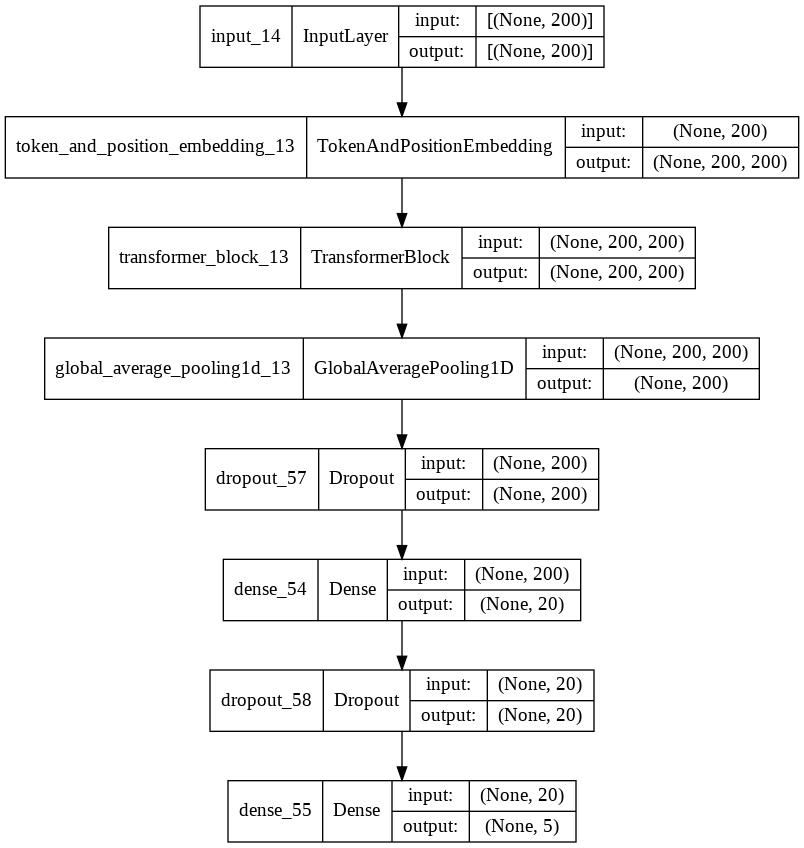

In [ ]:
tf.keras.utils.plot_model(model, to_file='transformer.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 4
batch_size = 32
loss = "categorical_crossentropy"
opt = keras.optimizers.Adam(lr=1e-04)

metrics = ["acc"]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

model.compile(optimizer=opt, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks = [callback])

Epoch 1/4
37/37 [==============================] - 50s 1s/step - loss: 1.6018 - acc: 0.2301 - val_loss: 1.6077 - val_acc: 0.3012
Epoch 2/4
37/37 [==============================] - 49s 1s/step - loss: 1.5526 - acc: 0.2695 - val_loss: 1.5739 - val_acc: 0.3133
Epoch 3/4
37/37 [==============================] - 48s 1s/step - loss: 1.5186 - acc: 0.3088 - val_loss: 1.5250 - val_acc: 0.3373
Epoch 4/4
37/37 [==============================] - 49s 1s/step - loss: 1.4908 - acc: 0.3388 - val_loss: 1.5753 - val_acc: 0.3253


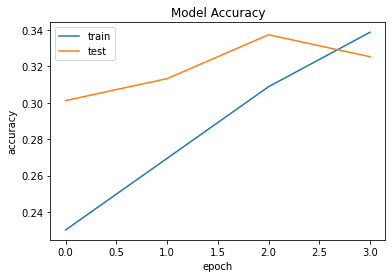

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

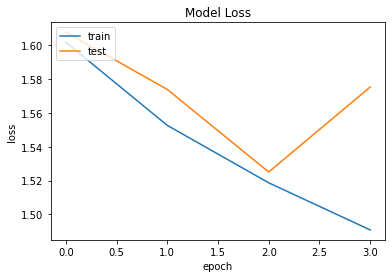

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

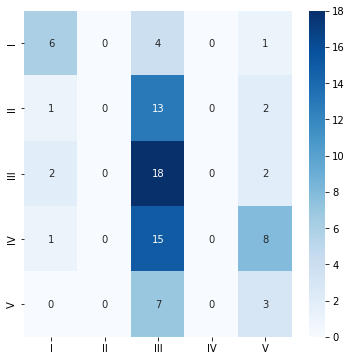

In [ ]:
#predict the labels
y_predicted_labels = model.predict(X_test)
y_pred_index = np.argmax(y_predicted_labels,axis=1)
y_original = np.argmax(y_test, axis =1)

#plot the confusion matrix
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label,fmt='g');

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.60      0.55      0.57        11
           1       0.00      0.00      0.00        16
           2       0.32      0.82      0.46        22
           3       0.00      0.00      0.00        24
           4       0.19      0.30      0.23        10

    accuracy                           0.33        83
   macro avg       0.22      0.33      0.25        83
weighted avg       0.19      0.33      0.22        83



In [ ]:
# lets try with different epochs and batch size
# epochs = 10 and batch size = 64

In [ ]:
epochs = 10
batch_size = 64
loss = "categorical_crossentropy"
opt = keras.optimizers.Adam(lr=1e-04)

metrics = ["acc"]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

model.compile(optimizer=opt, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks = [callback])

Epoch 1/10
19/19 [==============================] - 53s 3s/step - loss: 1.4679 - acc: 0.3430 - val_loss: 1.5822 - val_acc: 0.2651
Epoch 2/10
19/19 [==============================] - 49s 3s/step - loss: 1.4213 - acc: 0.4003 - val_loss: 1.5292 - val_acc: 0.2892
Epoch 3/10
19/19 [==============================] - 49s 3s/step - loss: 1.3762 - acc: 0.4217 - val_loss: 1.4962 - val_acc: 0.3253
Epoch 4/10
19/19 [==============================] - 53s 3s/step - loss: 1.3307 - acc: 0.4440 - val_loss: 1.4886 - val_acc: 0.3855
Epoch 5/10
19/19 [==============================] - 49s 3s/step - loss: 1.2840 - acc: 0.4790 - val_loss: 1.5135 - val_acc: 0.2892
Epoch 6/10
19/19 [==============================] - 49s 3s/step - loss: 1.2121 - acc: 0.5192 - val_loss: 1.4952 - val_acc: 0.3614
Epoch 7/10
19/19 [==============================] - 50s 3s/step - loss: 1.1212 - acc: 0.5646 - val_loss: 1.4644 - val_acc: 0.3855
Epoch 8/10
19/19 [==============================] - 49s 3s/step - loss: 1.0075 - acc: 0.62

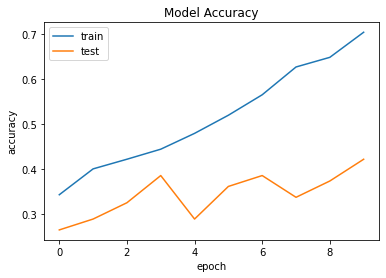

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

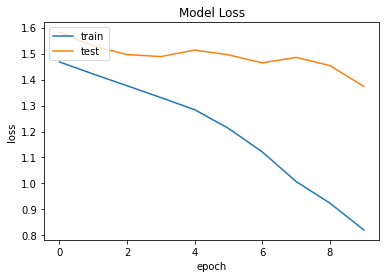

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

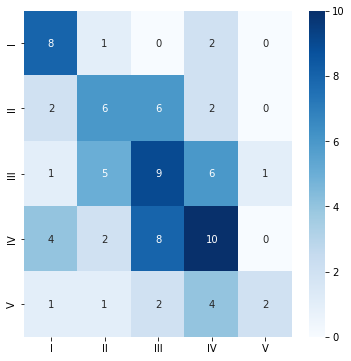

In [ ]:
#predict the labels
y_predicted_labels = model.predict(X_test)
y_pred_index = np.argmax(y_predicted_labels,axis=1)
y_original = np.argmax(y_test, axis =1)

#plot the confusion matrix
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label,fmt='g');

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.50      0.73      0.59        11
           1       0.40      0.38      0.39        16
           2       0.36      0.41      0.38        22
           3       0.42      0.42      0.42        24
           4       0.67      0.20      0.31        10

    accuracy                           0.42        83
   macro avg       0.47      0.43      0.42        83
weighted avg       0.44      0.42      0.41        83



In [ ]:
# save the model
model.save('/content/drive/MyDrive/AIML/Capstone/Models and Results/SimpleTransformer_Bal')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AIML/Capstone/Models and Results/SimpleTransformer_Bal/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AIML/Capstone/Models and Results/SimpleTransformer_Bal/assets


In [ ]:
with open('/content/drive/MyDrive/AIML/Capstone/Models and Results/bal_parameters.pickle', "wb") as f:
  pickle.dump((Lab_en, tokenizer), f)

In [ ]:
SimpleTransformer_Bal = load_model('/content/drive/MyDrive/AIML/Capstone/Models and Results/SimpleTransformer_Bal')

In [ ]:
y_pred = SimpleTransformer_Bal.predict(X_test, verbose=0) # Multiclass
y_pred_index = np.argmax(y_pred,axis=1)
y_original = np.argmax(y_test, axis =1)

In [ ]:
_,tr_accuracy = SimpleTransformer_Bal.evaluate(X_train,y_train) 
_,te_accuracy = SimpleTransformer_Bal.evaluate(X_test,y_test) 

F1_sre= f1_score(y_original,y_pred_index, average='weighted')
tr_accuracy,te_accuracy,F1_sre

3/3 [==============================] - 1s 381ms/step - loss: 1.3740 - acc: 0.4217


(0.8220701217651367, 0.42168673872947693, 0.4122231553907469)

In [ ]:
result_df.loc[len(result_df.index)] = ['Simple Transformer Model_Aug Balanced', tr_accuracy, te_accuracy,F1_sre] 
result_df.to_csv('/content/drive/MyDrive/AIML/Capstone/Models and Results/result_df.csv')
result_df

,Model,Train_accuracy,Test_accuracy,F1_score
0,LogReg,0.890244,0.890244,0.373494
1,Naive Bayes,1.000000,1.000000,0.421687
2,KNN,0.591463,0.591463,0.361446
3,SVM,0.990854,0.990854,0.361446
4,Decision Tree,0.512195,0.512195,0.313253
5,RandomForest,0.612805,0.612805,0.373494
6,Bagging,1.000000,1.000000,0.373494
7,AdaBoost,0.393293,0.393293,0.349398
8,Gradient Boost,0.920732,0.920732,0.325301
9,XGBoost,0.951220,0.951220,0.313253


In [ ]:
# plot the summary

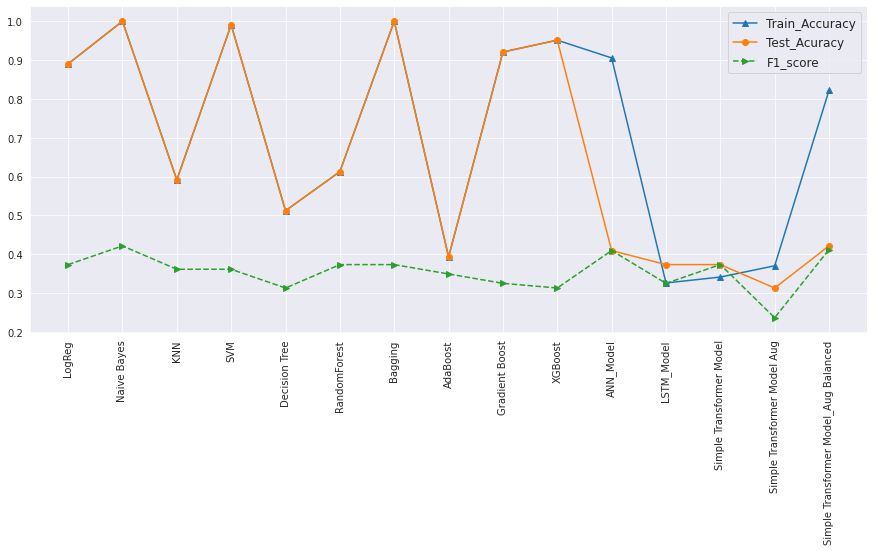

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.figure(figsize = (15,6))
sns.set_style("darkgrid")
plt.plot(result_df['Model'], result_df['Train_accuracy'], marker = '^', label = 'Train_Accuracy')
plt.plot(result_df['Model'], result_df['Test_accuracy'], marker = 'o', label = 'Test_Acuracy')
plt.plot(result_df['Model'], result_df['F1_score'], marker = '>', linestyle='--', label = 'F1_score')
plt.legend(fontsize = 12)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
result_df.set_index('Model',inplace = True)

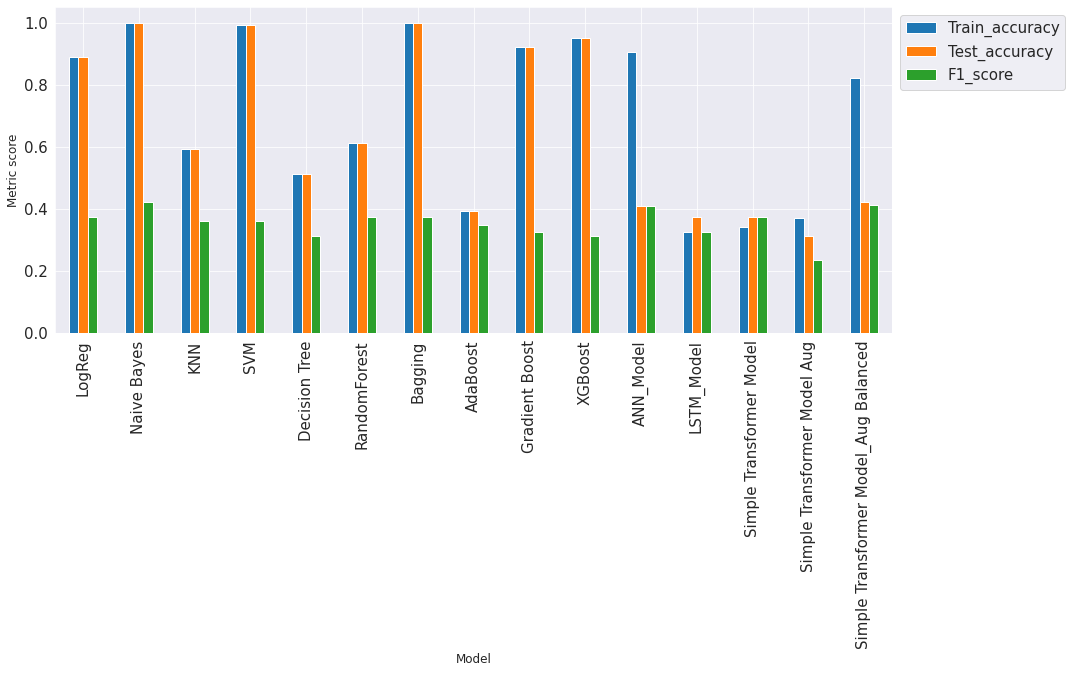

In [ ]:
ax = result_df.plot(kind='bar', rot = 0, figsize = (15,6), fontsize = 15) #,colormap='Pastel1') 
ax.legend(bbox_to_anchor=(1, 1), prop={'size': 15})
ax.set_ylabel("Metric score", fontsize=12)
ax.set_xlabel("Model", fontsize=12)
plt.xticks(rotation=90)
plt.show()